In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
#import jax
#jax.config.update('jax_platform_name', 'cpu')

In [1]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import scanpy as sc

2023-05-31 11:18:16.644307: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:429] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-05-31 11:18:16.644397: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:438] Possibly insufficient driver version: 525.105.17


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

: 

In [2]:
adata = sc.read("../../../../data/adata_pancreas_2022_processed_new.h5ad")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


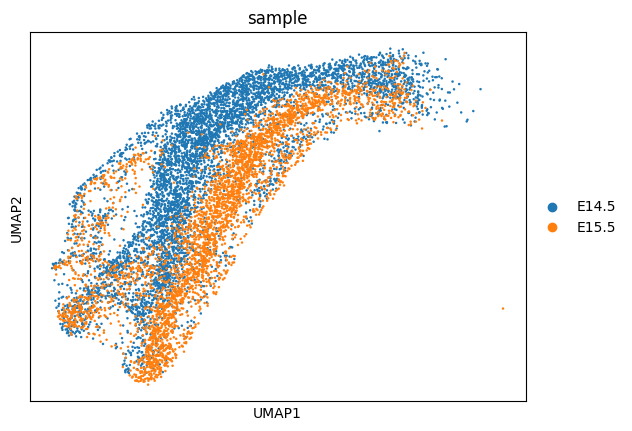

In [3]:
sc.pl.umap(adata, color="sample")

In [31]:
sc.pp.pca(adata, n_comps=10)

In [32]:
source = adata[adata.obs["sample"]=="E14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["sample"]=="E15.5"].obsm["X_pca"].copy()

In [1]:
from entot.models.utils import MLP
import flax.linen as nn

In [33]:
neural_net = MLP(dim_hidden=[64, 16, 8, 2, 8, 16, 64],
                is_potential=False,
                noise_dim=4,
                act_fn=nn.relu)

(5539, 10)

In [36]:
kg = KantorovichGapModel(epsilon=0.1, input_dim=[10], iterations=5000, neural_net=neural_net)

In [37]:
kg(source, target)

100%|██████████| 5000/5000 [56:08<00:00,  1.48it/s] 


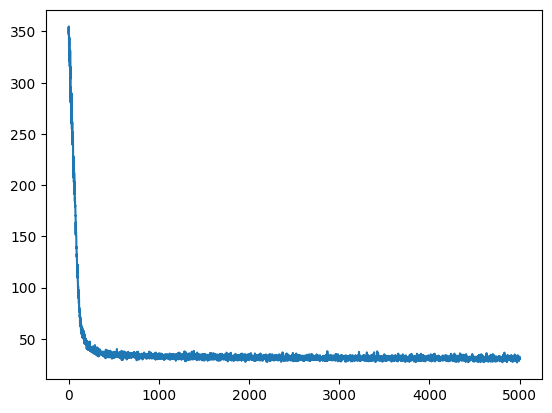

In [38]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["total_loss"])

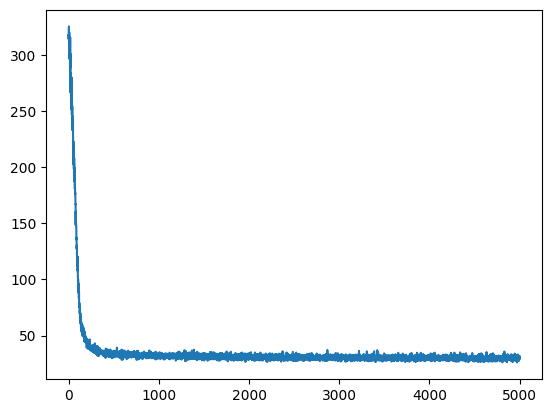

In [39]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

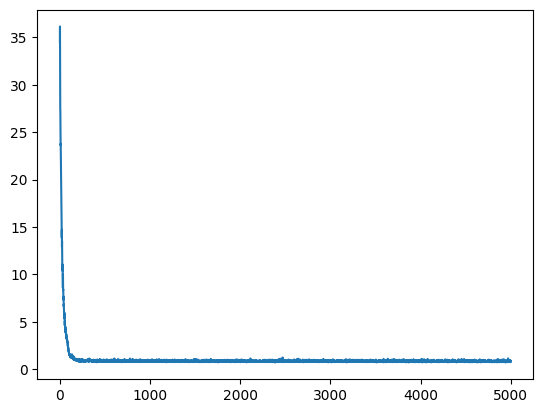

In [40]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["kant_gap"])

In [41]:
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(len(source), 4))

In [42]:
source_with_noise = jnp.concatenate((source, noise), axis=1)

In [43]:
pushed, intermediates = kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise, capture_intermediate=True)

In [ ]:
# analysis of the intermediate values

In [44]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed, target), axis=0)

In [45]:
del bdata.uns
del bdata.obsp

In [46]:
bdata.obsm

AxisArrays with keys: X_pca, X_pca_wsnn, X_spca_wsnn, X_umap, X_umap_ATAC, X_umap_GEX, X_umap_wsnn, lsi_full, lsi_red, umap, umap_ATAC, umap_GEX, X_pca_result

In [47]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

In [48]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


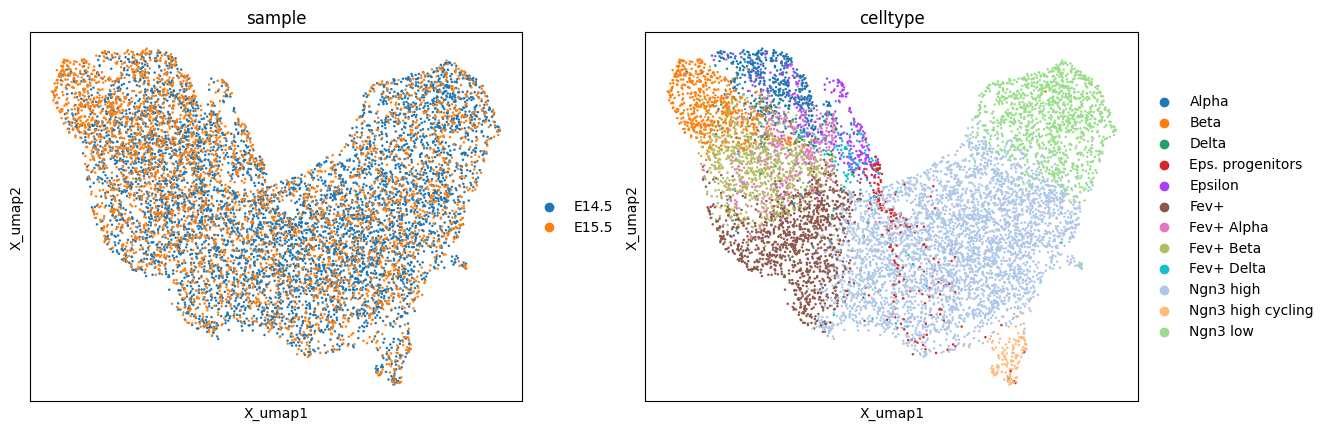

In [49]:
sc.pl.embedding(bdata, basis="X_umap", color=["sample", "celltype"])

In [50]:
res = [None] * 15

for i in range(15):
    noise = jax.random.normal(jax.random.PRNGKey(i), shape=(len(source), 4))
    source_with_noise = jnp.concatenate((source, noise), axis=1)
    res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)


In [51]:
samples = jnp.array(res)

In [52]:
samples.shape

(15, 5539, 10)

In [53]:
vars = jnp.var(samples, axis=0)

In [54]:
vars_summed = jnp.sum(vars, axis=1)

In [55]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

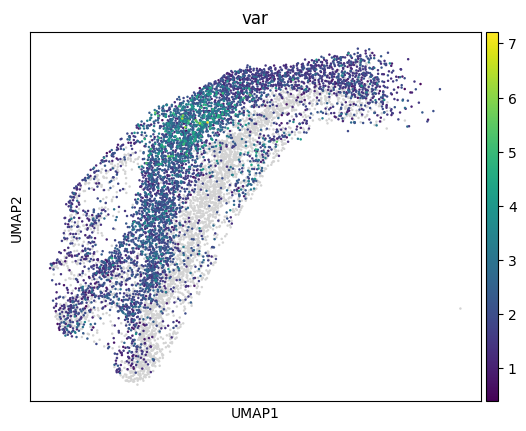

In [56]:
sc.pl.umap(bdata, color="var")

In [62]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Alpha,1.701161
Beta,1.512374
Delta,1.400051
Eps. progenitors,1.872609
Epsilon,1.570571
Fev+,2.026311
Fev+ Alpha,1.760879
Fev+ Beta,1.885538
Fev+ Delta,1.734424


In [57]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Alpha,1.698544
Beta,1.512367
Delta,1.400615
Eps. progenitors,1.883259
Epsilon,1.602581
Fev+,2.027206
Fev+ Alpha,1.746847
Fev+ Beta,1.878566
Fev+ Delta,1.751723


In [76]:
from typing import Callable, Optional, Tuple, Union, List
import scipy.sparse as sp


def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  # type:ignore[override]
        transport_map: Callable[[jnp.ndarray], jnp.ndarray],
        src_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 30,
        length_scale: Optional[float] = None,
        seed: int = 42,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        if length_scale is None:
            key = jax.random.PRNGKey(seed)
            src_batch = jax.random.choice(key, src_cells.shape[0], shape=((batch_size,)))
            tgt_batch = jax.random.choice(key, tgt_cells.shape[0], shape=((batch_size,)))
            mapped_batch = transport_map(src_cells[src_batch,:])
            length_scale = jnp.std(jnp.concatenate((mapped_batch, tgt_cells[tgt_batch,:])))
        for index in range(0, len(src_cells), batch_size):
            distances, indices = get_knn_fn(transport_map(src_cells[index : index + batch_size]), tgt_cells, k)
            distances = jnp.exp(-((distances / length_scale) ** 2))
            distances /= jnp.expand_dims(jnp.sum(distances, axis=1), axis=1)
            distances_list.append(distances.flatten())
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(src_cells) - index)), min(k, len(tgt_cells)))
            )
        distances = jnp.concatenate(distances_list)
        row_indices = jnp.concatenate(row_indices)
        column_indices = jnp.concatenate(column_indices)
        tm = sp.csr_matrix((distances, (row_indices, column_indices)), shape=[len(src_cells), len(tgt_cells)])
        return tm

In [75]:
r = lambda x: kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, x)
key = jax.random.PRNGKey(0)
src_batch = jax.random.choice(key, source_with_noise.shape[0], shape=((1024,)))
print(source_with_noise[src_batch].shape)
r2 = r(source_with_noise[src_batch][:,])

(1024, 14)


In [77]:
tm = project_transport_matrix(lambda x: kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, x), source_with_noise, target)

In [84]:
import pandas as pd
tm_df = pd.DataFrame(data=tm.A, index=adata[adata.obs["sample"]=="E14.5"].obs.index, columns = adata[adata.obs["sample"]=="E15.5"].obs.index)

In [101]:
np.isnan(tm_df.values).sum()

0

In [112]:
adata_early = adata[adata.obs["sample"]=="E14.5"]
adata_late = adata[adata.obs["sample"]=="E15.5"]

df_res = pd.DataFrame(index=adata_early.obs["celltype"].cat.categories)
for ct in adata_late.obs["celltype"].cat.categories:
    cols_cell_type = adata_late[adata_late.obs["celltype"] == ct].obs.index
    for ct2 in adata_early.obs["celltype"].cat.categories:
        index_cell_type = adata_early[adata_early.obs["celltype"] == ct2].obs.index
        df_res.loc[ct2, ct] = tm_df.loc[index_cell_type, cols_cell_type].sum().sum()


In [114]:
df_res.div(df_res.sum(axis=1), axis=0)

,Alpha,Beta,Delta,Eps. progenitors,Epsilon,Fev+,Fev+ Alpha,Fev+ Beta,Fev+ Delta,Ngn3 high,Ngn3 high cycling,Ngn3 low
Alpha,0.672847,0.118242,0.018099,0.000000,0.013031,0.000219,0.102672,0.072571,0.002319,0.000000,0.000000,0.000000
Beta,0.002848,0.957449,0.001078,0.000000,0.000000,0.000000,0.000645,0.037980,0.000000,0.000000,0.000000,0.000000
Delta,0.085739,0.326539,0.158509,0.000000,0.018029,0.005865,0.106506,0.262881,0.035932,0.000000,0.000000,0.000000
Eps. progenitors,0.000000,0.000000,0.001200,0.400345,0.086828,0.016941,0.000042,0.000243,0.087601,0.406800,0.000000,0.000000
Epsilon,0.154174,0.011731,0.046883,0.046223,0.499913,0.006213,0.057084,0.021593,0.151783,0.004402,0.000000,0.000000
Fev+,0.000026,0.001054,0.001189,0.000305,0.000562,0.736398,0.044369,0.176370,0.003177,0.033769,0.002781,0.000000
Fev+ Alpha,0.133081,0.016307,0.015727,0.000002,0.002590,0.028700,0.437279,0.343034,0.019598,0.000055,0.003626,0.000000
Fev+ Beta,0.005390,0.225617,0.003975,0.000000,0.000000,0.045719,0.046275,0.669821,0.000927,0.000101,0.000000,0.002176
Fev+ Delta,0.054900,0.011914,0.070257,0.053183,0.146766,0.110170,0.141342,0.108734,0.244127,0.058607,0.000000,0.000000
Ngn3 high,0.000000,0.000014,0.000019,0.018185,0.000031,0.050418,0.000417,0.000740,0.001339,0.922148,0.001010,0.005679
